In [1]:
# Import functions and libraries
from __future__ import division
%pylab
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys
from numpy import *
from scipy import *
import scipy.signal as signal
from rtlsdr import RtlSdr
from numpy.fft import *
from scipy import signal

import serial
%matplotlib inline


Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [15]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    
def phase_plot(t_range, f_range, y, dbf = 60):
    eps = 1e-3
    
#     # find maximum
#     y_max = abs(y).max()
    
#     # compute 20*log magnitude, scaled to the max
#     y_log = 20.0 * np.log10( abs( y ) / y_max + eps )

    y_phase = np.angle(y)
    
    fig=figure(figsize=(15,6))
    # 64.0*(y_phase + dbf)/dbf 
    plt.imshow( np.flipud(y_phase ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Phase')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def myspectrogram_phase_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        phase_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        phase_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf


def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

In [3]:
def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name

In [4]:
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 Built-in Microph
1 Built-in Output


In [5]:
dusb_in = 2
dusb_out = 2
din = 0
dout = 1

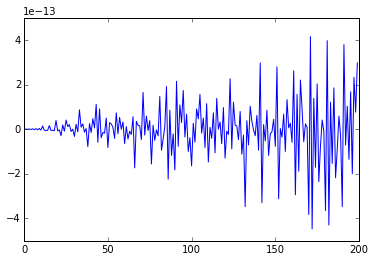

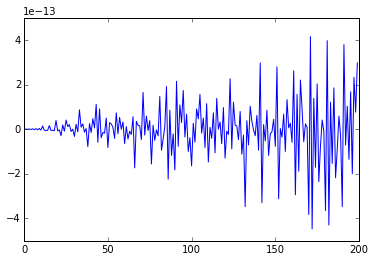

In [75]:
fc = 5e3 #434e6
fs = 10e3 #44100
sec = 1 #number of seconds
n_samples = sec * fs
t = np.arange(n_samples) * (1/fs)
sig = 3*sin(fc*t*2*pi)


figure()
plt.plot((sig)[:200])

sig = signal.hilbert(sig)

figure()
plt.plot((sig)[:200])

# p = pyaudio.PyAudio()

# Qout = Queue.Queue()

# # initialize a recording thread.
# t_play = threading.Thread(target = play_audio,   args = (Qout,   p, 44100, dout))


# # start the recording and playing threads
# t_play.start()

# Qout.put( sig );

# while not(Qout.empty()) :
#     time.sleep(1)

# # terminate pyAudio
# p.terminate()

In [71]:
#generate received signals
delay_bit0 = np.random.randn( 128 ) 
y0 = sig + 0.01 * np.random.randn( len(sig) )
y0 = np.concatenate((y0[-128:], y0[:-128]))

y1 = sig + 0.01 * np.random.randn( len(sig) )
delay_bit1 = np.random.randn( 128 )
y1 = np.concatenate(( y0[:128], y1[:-128]))


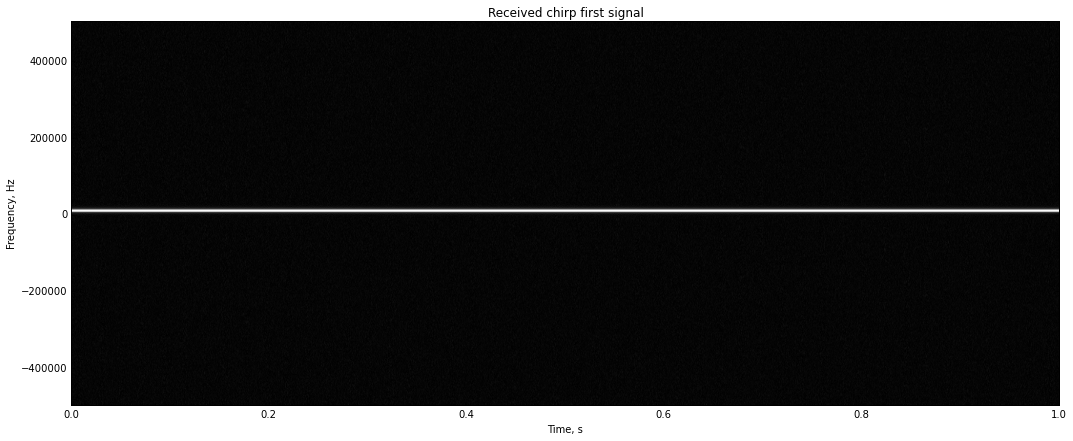

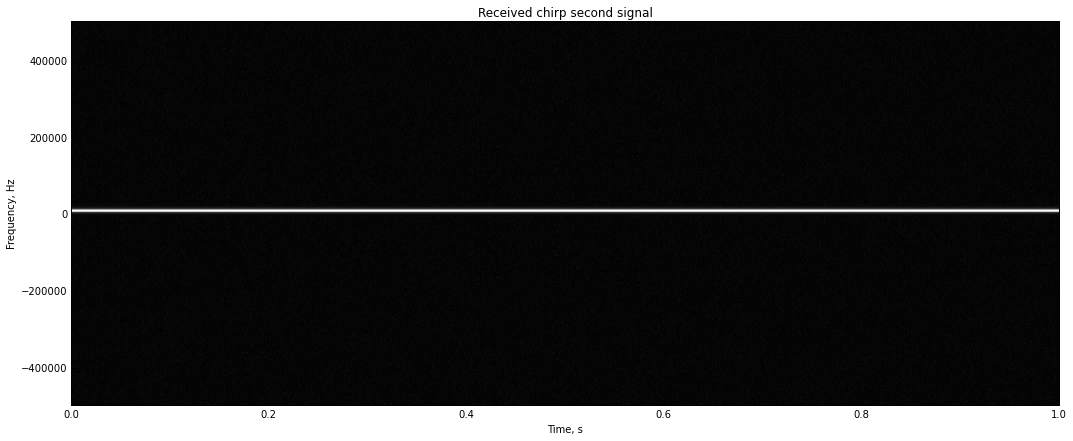

In [72]:
m = 512

myspectrogram_hann_ovlp(y0, m, fs, fc, dbf = 60)
plt.title('Received chirp first signal')
myspectrogram_hann_ovlp(y1, m, fs, fc, dbf = 60)
plt.title('Received chirp second signal')

504345
504345
504345
500764


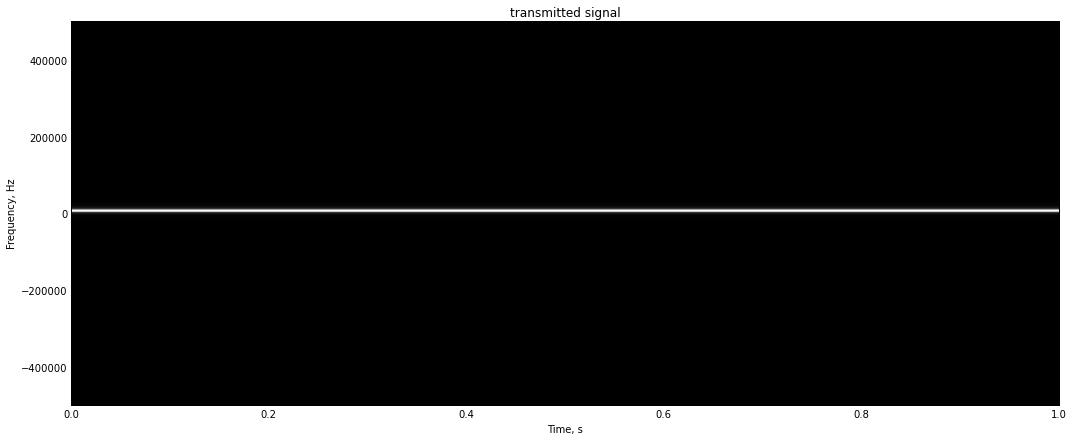

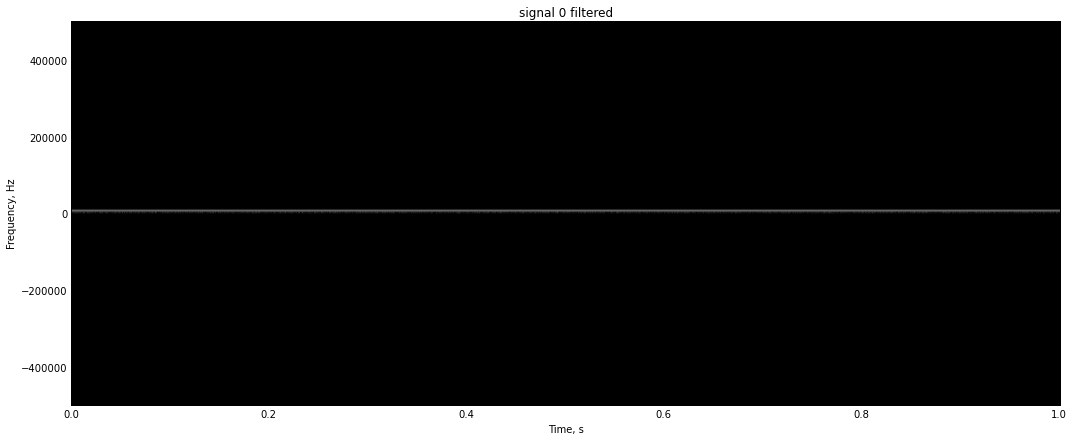

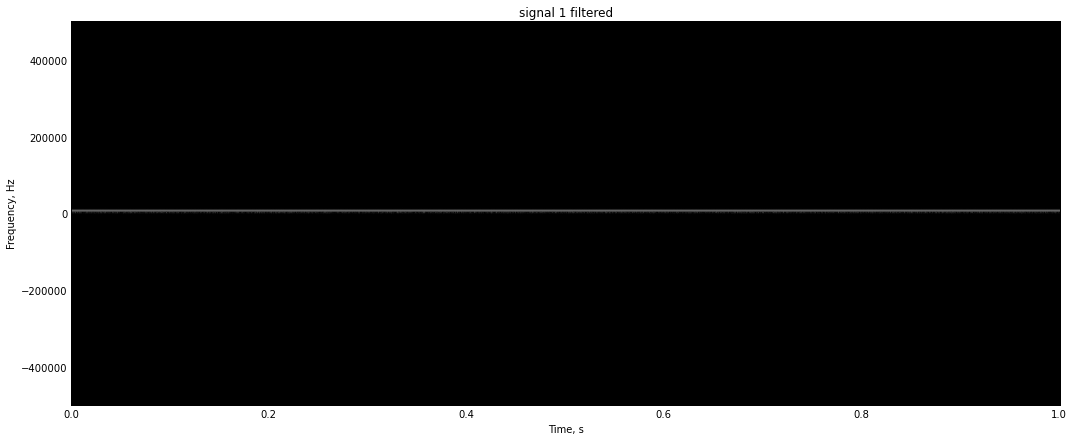

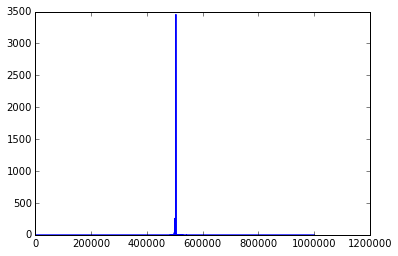

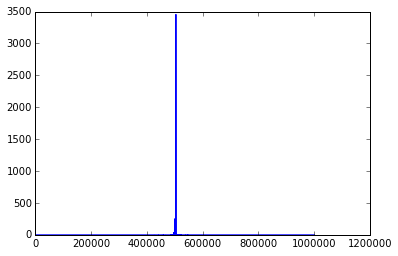

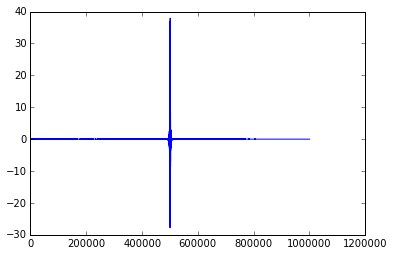

In [73]:
taps = 685
# taps = 700

mod_val = 0 # fc - 430e6
h = sp.signal.firwin(taps, 1/fs)
t = np.arange(taps) * (1/fs)
mod = exp(-1j*2*pi*mod_val*t)
h = h*mod

filt_sig = signal.fftconvolve(sig, h)
filt_y0 = signal.fftconvolve(y0, h)
filt_y1 = signal.fftconvolve(y1, h)


myspectrogram_hann_ovlp(sig, m, fs, fc,dbf = 63)
title('transmitted signal')
myspectrogram_hann_ovlp(filt_y0, m, fs, fc,dbf = 63)
title('signal 0 filtered')
myspectrogram_hann_ovlp(filt_y1, m, fs, fc,dbf = 63)
title('signal 1 filtered')

freqsig = np.fft.fftshift(np.fft.fft(filt_sig)) 
freq0 = np.fft.fftshift(np.fft.fft(filt_y0)) 
freq1 = np.fft.fftshift(np.fft.fft(filt_y1)) 
figure()
plt.plot(abs(freq0))
figure()
plt.plot(abs(freq1))

print np.argmax(abs(freqsig))
print np.argmax(abs(freq0))
print np.argmax(abs(freq1))
print np.argmax(abs(freq0)-abs(freq1))

figure()
plt.plot((abs(freq0)-abs(freq1))) #[225000:275000]


684
684
1
1
0
0


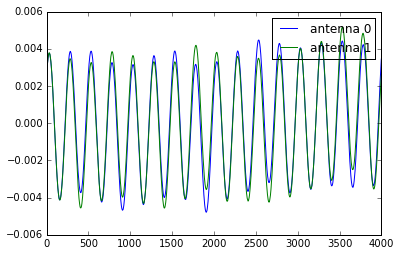

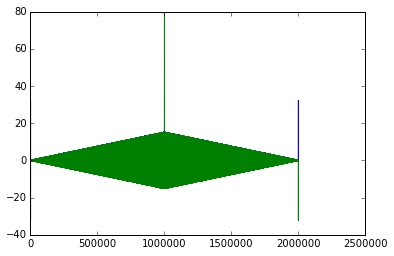

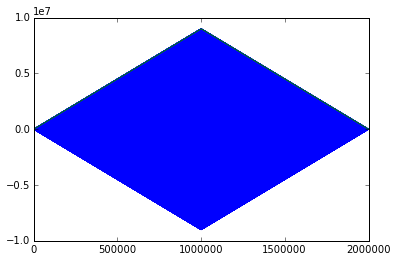

In [74]:
# Calculating USB delay

figure()
plt.plot(filt_y0[1000:5000], label='antenna 0')
plt.plot(filt_y1[1000:5000], label='antenna 1')
plt.legend()

# figure()
# plt.plot(filt_y0, label='antenna 0')
# plt.plot(filt_y1, label='antenna 1')
# plt.legend()


filt_xcorr_abs = abs(signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1]))
filt_xcorr = signal.fftconvolve(filt_y0, np.conjugate(filt_y1)[::-1])
filt_trun_xcorr_abs = abs(signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))]))
filt_trun_xcorr = signal.fftconvolve(filt_y0[int(len(h)/2)-1:-(int(len(h)/2))], (np.conjugate(filt_y1)[::-1])[int(len(h)/2)-1:-(int(len(h)/2))])

figure()
plt.plot(filt_xcorr_abs)
plt.plot(filt_xcorr)

# figure()
# plt.plot(filt_trun_xcorr_abs)
# plt.plot(filt_trun_xcorr)

orig_xcorr = signal.fftconvolve(y0, np.conjugate(y1)[::-1])
orig_xcorr_abs = abs(signal.fftconvolve(y0, np.conjugate(y1)[::-1]))

figure()
plt.plot(orig_xcorr)
plt.plot(orig_xcorr_abs)

print np.argmax(filt_xcorr)-len(y0) + 1
print np.argmax(filt_xcorr_abs)-len(y0) + 1
print np.argmax(filt_trun_xcorr_abs)-len(y0) + 1
print np.argmax(filt_trun_xcorr)-len(y0) + 1
print np.argmax(orig_xcorr_abs)-len(y0) + 1
print np.argmax(orig_xcorr)-len(y0) + 1

delay = np.argmax(orig_xcorr_abs)-len(y0) + 1

In [ ]:
# 1031 1044
phase_diff = np.angle(y0[delay:] * np.conjugate(y1[:-delay]))
# phase_diff = np.angle(y0[:delay] * np.conjugate(y1[-delay:]))
figure()
plt.plot(phase_diff)

print np.mean(phase_diff[:100000])

phase_diff = np.angle(filt_y0[1691:] * np.conjugate(filt_y1[:-1691]))
figure()
plt.plot(phase_diff)

print np.mean(phase_diff[:800000])


In [ ]:
phase_sweep = exp(-1j*np.arange(-0.5,0.5,1/20) * 2 * pi)
all_summed = []
for phase in phase_sweep:
    summed = filt_y0[1691:] + phase * filt_y1[:-1691]
#     all_summed.append(max(abs(summed)))
    all_summed.append(np.dot(summed, np.conjugate(summed)))
    
ind = np.argmax(np.array(all_summed))

# print all_summed
print np.argmax(all_summed)
print np.angle(phase_sweep[ind]) #- 0.668876084193 # - (-0.624638572552)